In [1]:
"""
Rooftop Image Classification from Satellite Imagery
Denver,CO

Brittany Bennett
December 2018 
"""

"""
Given an image, perform random transformations to generate new data. 
 
"""

# Import the necessary packages
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np

IMAGE_SIZE    = (256, 256)
CROP_LENGTH   = 224
NUM_CLASSES   = 2
BATCH_SIZE    = 8  # try reducing batch size or freeze more layers if your GPU runs out of memory
FREEZE_LAYERS = 2  # freeze the first this many layers for training
NUM_EPOCHS    = 20




In [2]:
from keras.preprocessing.image import ImageDataGenerator,img_to_array, load_img

/home/thebbennett/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
os.getcwd()

'/home/thebbennett/rooftopNN'

In [4]:
os.chdir("/home/thebbennett/rooftopNN/Images/compressed/images/")

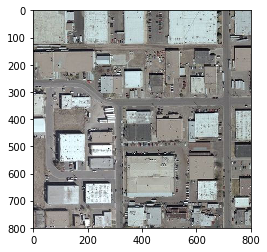

In [5]:
path ="036719ne051sw_compressed_resized.jpg"
img=mpimg.imread(path)
imgplot = plt.imshow(img)

In [6]:
datagen = ImageDataGenerator(
        brightness_range = (0.5, 1.5),
        horizontal_flip=True,
        vertical_flip = True,
        fill_mode='nearest')

In [7]:
def random_crop(img, random_crop_size):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :]

In [8]:
def crop_generator(batches, crop_length):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """
    while True:
        batch_x, batch_y = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], crop_length, crop_length, 3))
        for i in range(batch_x.shape[0]):
            batch_crops[i] = random_crop(batch_x[i], (crop_length, crop_length))
        yield (batch_crops, batch_y)

In [9]:
from tensorflow.python.keras.applications.resnet50 import ResNet50, preprocess_input

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=10,
                                   horizontal_flip=True,
                                   fill_mode='nearest')


In [10]:
train_batches = train_datagen.flow_from_directory('/home/thebbennett/rooftopNN/Images/compressed/images/train',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE)


Found 83 images belonging to 1 classes.


In [11]:
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
valid_batches = valid_datagen.flow_from_directory('/home/thebbennett/rooftopNN/Images/compressed/images/valid',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  batch_size=BATCH_SIZE)


Found 83 images belonging to 1 classes.


In [12]:
train_crops = crop_generator(train_batches, CROP_LENGTH)
valid_crops = crop_generator(valid_batches, CROP_LENGTH)


In [13]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Flatten, Dense, Dropout
from tensorflow.python.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.python.keras.optimizers import Adam



net = ResNet50(include_top=False, weights='imagenet', input_tensor=None,
               input_shape=(CROP_LENGTH,CROP_LENGTH,3))
x = net.output
x = Flatten()(x)
x = Dropout(0.5)(x)
output_layer = Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)
net_final = Model(inputs=net.input, outputs=output_layer)
for layer in net_final.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in net_final.layers[FREEZE_LAYERS:]:
    layer.trainable = True
net_final.compile(optimizer=Adam(lr=1e-5),
                  loss='categorical_crossentropy', metrics=['accuracy'])
print(net_final.summary())

/home/thebbennett/.local/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [14]:
net_final.fit_generator(train_crops,
                        steps_per_epoch = train_batches.samples // BATCH_SIZE,
                        validation_data = valid_crops,
                        validation_steps = valid_batches.samples // BATCH_SIZE,
                        epochs = NUM_EPOCHS)


Epoch 1/20


ValueError: Error when checking target: expected softmax to have shape (2,) but got array with shape (1,)

In [ ]:
train_batches = datagen.flow_from_directory("/home/thebbennett/rooftopNN/Images/compressed/images/",target_size=(256,256),batch_size=32,class_mode='binary')
train_crops = crop_generator(train_batches, 10)


In [ ]:
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


In [ ]:
valid_batches = valid_datagen.flow_from_directory(DATASET_PATH + '/valid',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  batch_size=BATCH_SIZE)


In [ ]:
valid_crops = crop_generator(valid_batches, CROP_LENGTH)
